<a href="https://colab.research.google.com/github/syedanida/Computer-Vision/blob/main/Part_3_Zero_Shot_Transfer_Learning_with_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bcs1vb5x
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bcs1vb5x
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import numpy as np
import torch
import clip
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [ ]:
def load_clip_model():
    """Load the CLIP model."""
    model, preprocess = clip.load("ViT-B/32", device=device)
    return model, preprocess

In [ ]:
def get_cifar100_classes():
    """Get CIFAR100 class names."""
    dataset = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)
    return dataset.classes

In [ ]:
def load_sample_images(dataset_path, num_samples=5):
    """Load sample images for testing."""
    # For this example, we'll use CIFAR100 test set
    test_dataset = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False,
                          transform=transforms.ToTensor())

    # Get a few random samples
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    images = []
    labels = []

    for idx in indices:
        image, label = test_dataset[idx]
        # Convert from tensor to PIL Image
        img = transforms.ToPILImage()(image)
        images.append(img)
        labels.append(label)

    return images, labels, test_dataset.classes

In [ ]:
def create_prompt_templates(class_names):
    """Create different prompt templates for zero-shot classification."""
    templates = {
        "simple": lambda c: c,
        "a_photo_of": lambda c: f"a photo of a {c}",
        "an_image_of": lambda c: f"an image of a {c}",
        "a_photo_of_the": lambda c: f"a photo of the {c}",
        "a_blurry_photo_of": lambda c: f"a blurry photo of a {c}",
        "a_sketch_of": lambda c: f"a sketch of a {c}",
    }

    # Apply templates to class names
    prompted_classes = {}
    for template_name, template_func in templates.items():
        prompted_classes[template_name] = [template_func(c) for c in class_names]

    return prompted_classes

In [ ]:
def zero_shot_predict(model, image, preprocess, class_prompts):
    """Perform zero-shot prediction on an image."""
    # Preprocess the image
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Tokenize text prompts
    text_inputs = torch.cat([clip.tokenize(prompt) for prompt in class_prompts]).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Normalize features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    # Get top predictions
    values, indices = similarity[0].topk(5)

    return values.cpu().numpy(), indices.cpu().numpy()

In [ ]:
def compare_prompt_templates(model, image, preprocess, prompted_classes, original_classes):
    """Compare performance of different prompt templates."""
    results = {}

    for template_name, class_prompts in prompted_classes.items():
        values, indices = zero_shot_predict(model, image, preprocess, class_prompts)
        results[template_name] = {
            'probs': values,
            'classes': [original_classes[idx] for idx in indices],
            'indices': indices
        }

    return results

In [ ]:
def test_out_of_distribution(model, image, preprocess, original_classes):
    """Test with out-of-distribution classes."""
    # Original classes
    original_prompts = [f"a photo of a {c}" for c in original_classes]

    # Add some out-of-distribution classes
    ood_classes = ["smartphone", "laptop", "robot", "spaceship", "alien", "dinosaur"]
    ood_prompts = [f"a photo of a {c}" for c in ood_classes]

    # Combine all prompts
    combined_prompts = original_prompts + ood_prompts
    combined_classes = original_classes + ood_classes

    # Get predictions
    values, indices = zero_shot_predict(model, image, preprocess, combined_prompts)

    return {
        'probs': values,
        'classes': [combined_classes[idx] for idx in indices],
        'indices': indices,
        'combined_classes': combined_classes
    }

In [ ]:
def plot_predictions(results, true_class, image, ood_results=None):
    """Visualize prediction results."""
    n_templates = len(results)
    fig, axs = plt.subplots(1, n_templates + 1, figsize=(15, 5))

    # Show the image in the first subplot
    axs[0].imshow(image)
    axs[0].set_title(f"True: {true_class}")
    axs[0].axis('off')

    # Plot predictions for each template
    for i, (template_name, result) in enumerate(results.items()):
        axs[i+1].barh(np.arange(len(result['probs'])), result['probs'])
        axs[i+1].set_yticks(np.arange(len(result['probs'])))
        axs[i+1].set_yticklabels(result['classes'])
        axs[i+1].set_title(f"Template: {template_name}")
        axs[i+1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # If OOD results provided, plot them
    if ood_results:
        plt.figure(figsize=(10, 5))
        plt.barh(np.arange(len(ood_results['probs'])), ood_results['probs'])
        plt.yticks(np.arange(len(ood_results['probs'])), ood_results['classes'])
        plt.title("Predictions with OOD Classes")
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

In [ ]:
def evaluate_on_dataset(model, preprocess, num_samples=100):
    """Evaluate zero-shot performance on a subset of CIFAR100."""
    # Load CIFAR100 dataset
    test_dataset = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)
    classes = test_dataset.classes

    # Create transform that includes CLIP preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.ToPILImage()(x))  # Convert to PIL Image for CLIP preprocess
    ])

    # Create a smaller evaluation dataset
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    eval_images = []
    eval_labels = []

    for idx in indices:
        image, label = test_dataset[idx]
        eval_images.append(transform(image))
        eval_labels.append(label)

    # Prepare text prompts (using the 'a_photo_of' template)
    text_prompts = [f"a photo of a {c}" for c in classes]
    text_inputs = torch.cat([clip.tokenize(prompt) for prompt in text_prompts]).to(device)

    # Encode text prompts (only need to do this once)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Predict on each image
    predictions = []
    for image in eval_images:
        # Preprocess and encode image
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Calculate similarity and get prediction
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        _, prediction = similarity[0].topk(1)
        predictions.append(prediction.item())

    # Calculate accuracy
    correct = sum(pred == label for pred, label in zip(predictions, eval_labels))
    accuracy = correct / len(eval_labels)

    # Generate confusion matrix
    cm = confusion_matrix(eval_labels, predictions, labels=np.arange(len(classes)))

    return accuracy, cm, classes

In [ ]:
def plot_confusion_matrix(cm, classes, top_n=10):
    """Plot a confusion matrix for the top N most confused classes."""
    # Sum confusion across rows and columns to find most confused classes
    class_errors = cm.sum(axis=1) - np.diag(cm)
    top_confused_idx = np.argsort(class_errors)[-top_n:]

    # Extract submatrix for top confused classes
    cm_subset = cm[top_confused_idx][:, top_confused_idx]
    class_names_subset = [classes[i] for i in top_confused_idx]

    # Plot
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_subset, display_labels=class_names_subset)
    disp.plot(xticks_rotation=45)
    plt.title(f"Confusion Matrix for Top {top_n} Most Confused Classes")
    plt.tight_layout()
    plt.show()

In [ ]:
def main():
    # Load CLIP model
    model, preprocess = load_clip_model()

    # Get class names
    cifar100_classes = get_cifar100_classes()

    # Load sample images
    images, labels, class_names = load_sample_images("~/.cache", num_samples=3)

    print(f"Loaded {len(images)} images with labels: {[class_names[l] for l in labels]}")

    # Create different prompt templates
    prompted_classes = create_prompt_templates(cifar100_classes)

    # Process each sample image
    for i, (image, label) in enumerate(zip(images, labels)):
        print(f"\nAnalyzing image {i+1} (true class: {class_names[label]})")

        # Compare different prompt templates
        template_results = compare_prompt_templates(model, image, preprocess, prompted_classes, cifar100_classes)

        # Test with out-of-distribution classes
        ood_results = test_out_of_distribution(model, image, preprocess, cifar100_classes)

        # Visualize results
        plot_predictions(template_results, class_names[label], image, ood_results)

    # Evaluate on a larger subset of the dataset
    print("\nEvaluating on a subset of CIFAR100...")
    accuracy, cm, classes = evaluate_on_dataset(model, preprocess, num_samples=100)
    print(f"Zero-shot accuracy: {accuracy:.2%}")

    # Plot confusion matrix
    plot_confusion_matrix(cm, classes, top_n=10)

Loaded 3 images with labels: ['crab', 'dinosaur', 'seal']

Analyzing image 1 (true class: crab)


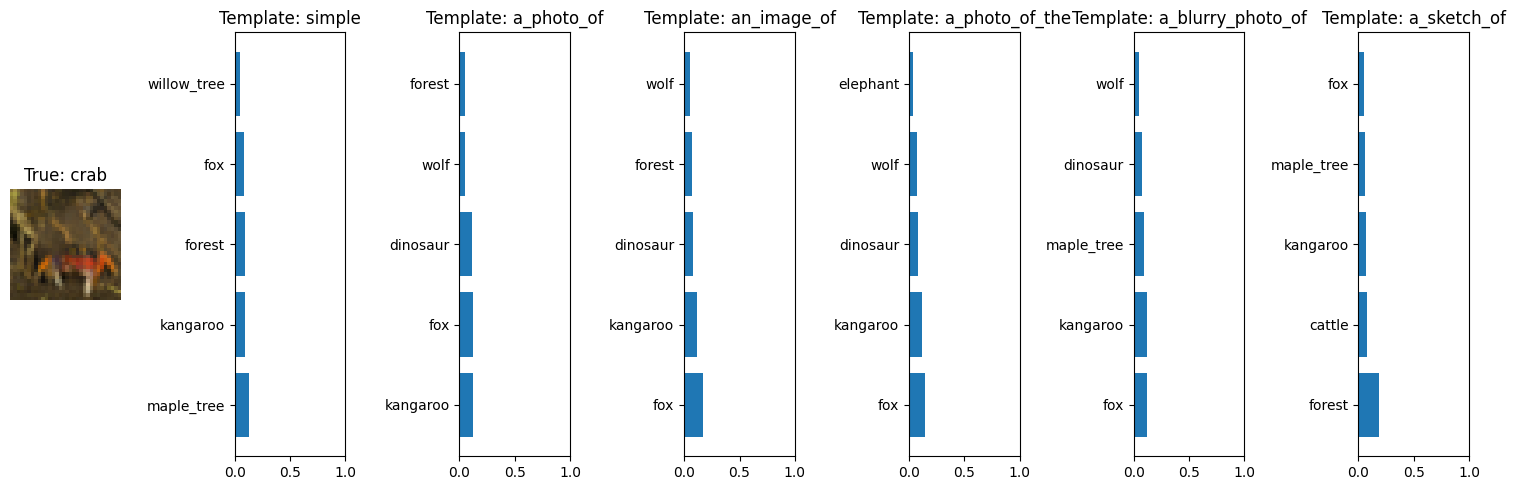

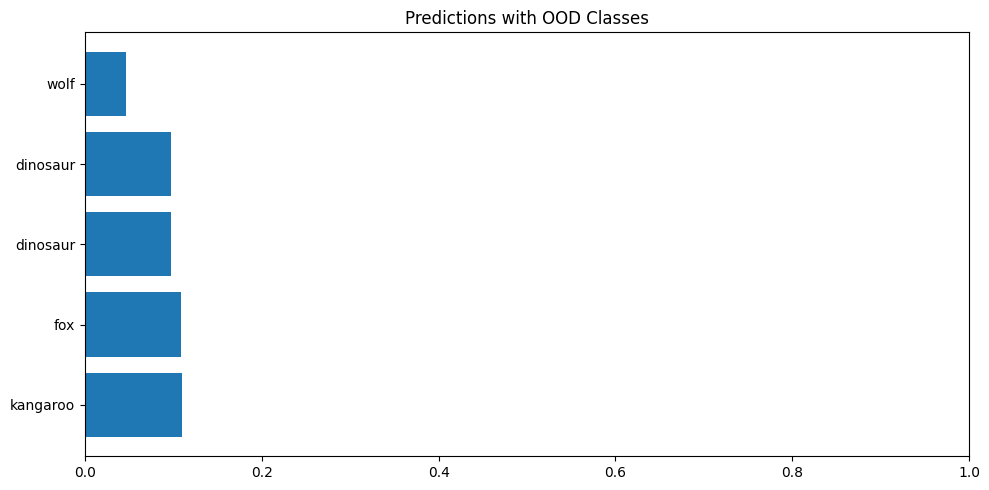


Analyzing image 2 (true class: dinosaur)


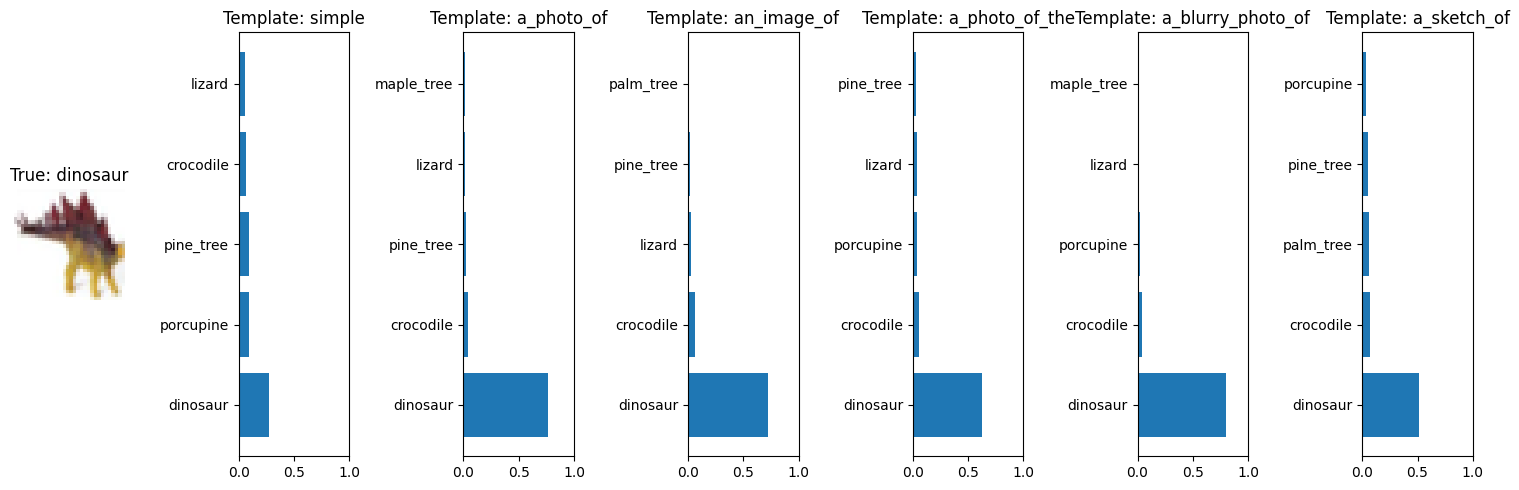

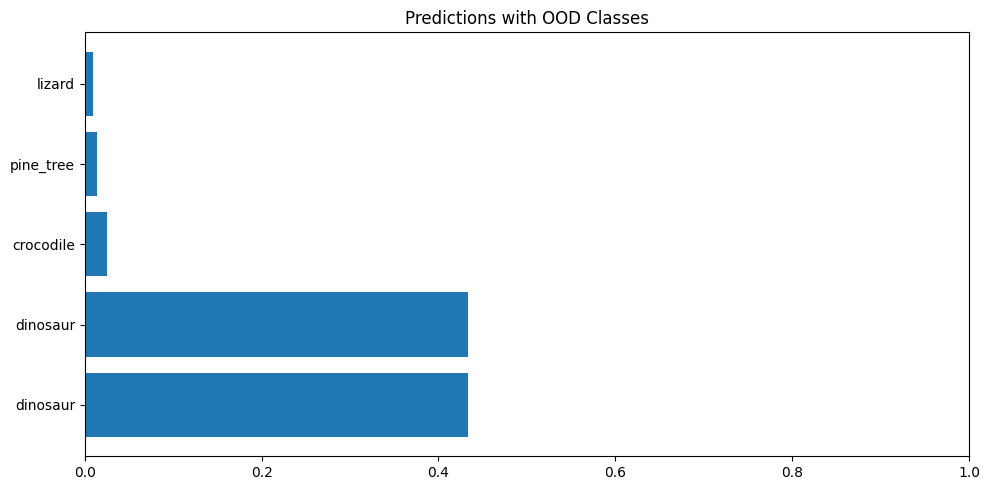


Analyzing image 3 (true class: seal)


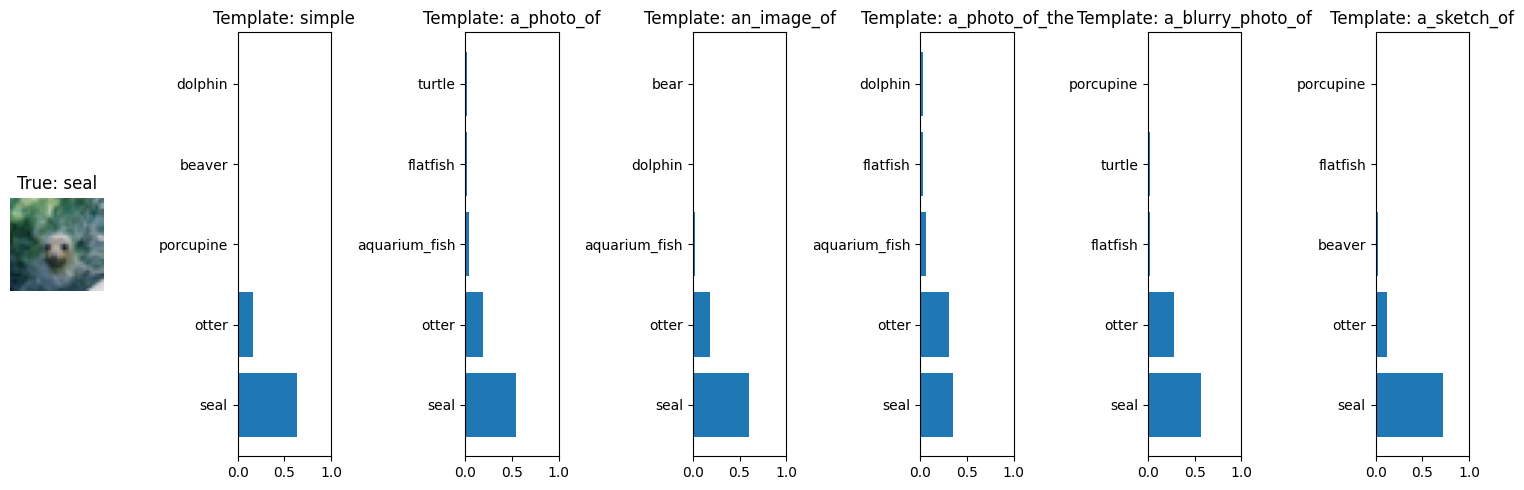

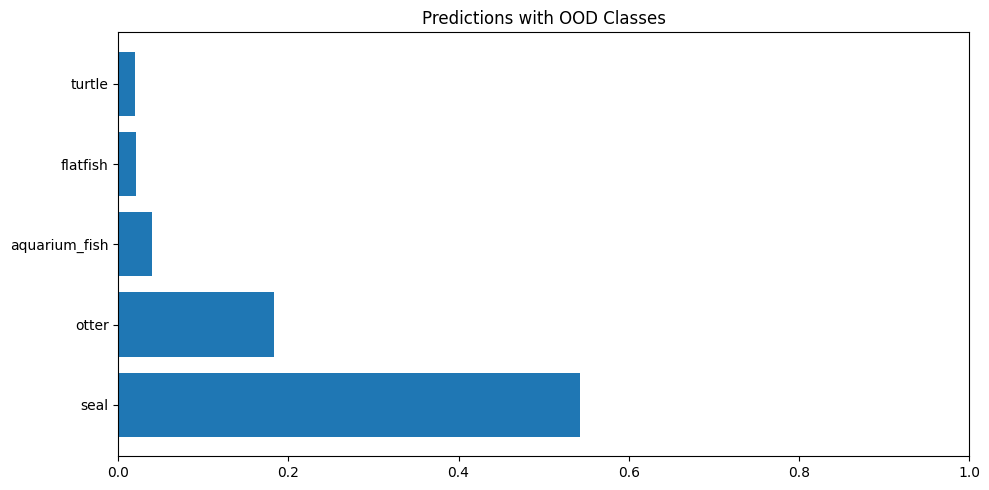


Evaluating on a subset of CIFAR100...
Zero-shot accuracy: 70.00%


<Figure size 1000x800 with 0 Axes>

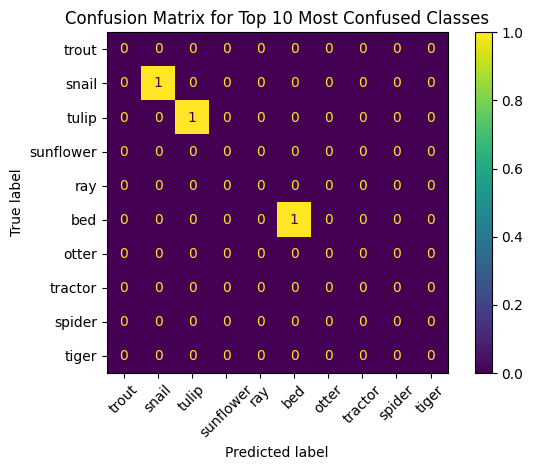

In [ ]:
if __name__ == "__main__":
    main()